Este colab fue desarrollado por Arnold Charry Armero.

# AdaBoost (Regresión)

AdaBoost para regresión, conocido como AdaBoost.R2, es una extensión del algoritmo AdaBoost diseñado para problemas de predicción de valores continuos. Al igual que en clasificación, su objetivo es combinar varios modelos débiles (generalmente árboles de decisión de baja profundidad) para formar un predictor fuerte y más preciso.  

La idea central se mantiene: entrenar los modelos débiles de manera secuencial, donde cada nuevo estimador se enfoca en mejorar el desempeño del conjunto al atender los errores cometidos por los anteriores. En regresión se utilizan errores relativos de predicción para ajustar la importancia de cada observación. El paso a paso es el siguiente:  


1. A cada observación se le asigna inicialmente el mismo peso.  

2. En cada iteración $m$:  

   - Se entrena un regresor débil $h_m(x)$ usando los datos ponderados.  
   - Se calcula el error relativo de cada observación:  

     $$
     L_i = \frac{|y_i - h_m(x_i)|}{\max_j |y_j - h_m(x_j)|}, \quad L_i \in [0,1]
     $$  

   - A partir de estas pérdidas, se obtiene el error ponderado del modelo:  

     $$
     \varepsilon_m = \sum_{i=1}^n w_i \, L_i
     $$  

3. Se calcula un parámetro $\beta_m$ que refleja la importancia del modelo:  

   $$
   \beta_m = \frac{\varepsilon_m}{1 - \varepsilon_m}
   $$  

   Cuanto más bajo es el error $\varepsilon_m$, mayor es la influencia del modelo en la predicción final.  

4. Las observaciones con mayor error relativo reciben un aumento en su peso, forzando al siguiente regresor a prestarles más atención:  

   $$
   w_i \leftarrow w_i \, \beta_m^{(1 - L_i)}
  $$

   Finalmente, los pesos se normalizan para que sumen 1.  

5. A diferencia de la versión para clasificación, en AdaBoost.R2 la predicción final se obtiene a través de una mediana ponderada de las salidas de los regresores:  

  $$
   H(x) = \text{weighted-median}\left( h_m(x), \log\frac{1}{\beta_m} \right)
  $$  

De este modo, los modelos que presentan menor error en el entrenamiento tienen un peso mayor en la predicción final, logrando que el ensamble sea más robusto que cada modelo individual.  

Ahora se continúa con la implementación en código,


In [ ]:
# Se importan las librerias
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_string_dtype
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/Cellphone.csv')

In [ ]:
df.head()

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


Se elimina la primer columna con el id, ya que no es una característica relevante.

In [ ]:
df = df.drop('Product_id', axis = 1)

Se vuelve a revisar la base de datos,

In [ ]:
df.head()

,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


Primero se analiza la base de datos,

In [ ]:
# Se verifica la cantidad de datos
df.shape

(161, 13)

Se puede observar que hay 161 filas. Se observará de qué tipo son estos valores y si hay faltantes.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         161 non-null    int64  
 1   Sale          161 non-null    int64  
 2   weight        161 non-null    float64
 3   resoloution   161 non-null    float64
 4   ppi           161 non-null    int64  
 5   cpu core      161 non-null    int64  
 6   cpu freq      161 non-null    float64
 7   internal mem  161 non-null    float64
 8   ram           161 non-null    float64
 9   RearCam       161 non-null    float64
 10  Front_Cam     161 non-null    float64
 11  battery       161 non-null    int64  
 12  thickness     161 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 16.5 KB


In [ ]:
# Se verifica el tema de los faltantes
df.isnull().sum()[df.isnull().sum() != 0]

,0


Ahora se analizan las características con datos relevantes,

In [ ]:
df.describe()

,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,2215.596273,621.465839,170.426087,5.209938,335.055901,4.857143,1.502832,24.501714,2.204994,10.378261,4.503106,2842.111801,8.921739
std,768.187171,1546.618517,92.888612,1.509953,134.826659,2.444016,0.599783,28.804773,1.609831,6.181585,4.342053,1366.990838,2.192564
min,614.000000,10.000000,66.000000,1.400000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,800.000000,5.100000
25%,1734.000000,37.000000,134.100000,4.800000,233.000000,4.000000,1.200000,8.000000,1.000000,5.000000,0.000000,2040.000000,7.600000
50%,2258.000000,106.000000,153.000000,5.150000,294.000000,4.000000,1.400000,16.000000,2.000000,12.000000,5.000000,2800.000000,8.400000
75%,2744.000000,382.000000,170.000000,5.500000,428.000000,8.000000,1.875000,32.000000,3.000000,16.000000,8.000000,3240.000000,9.800000
max,4361.000000,9807.000000,753.000000,12.200000,806.000000,8.000000,2.700000,128.000000,6.000000,23.000000,20.000000,9500.000000,18.500000


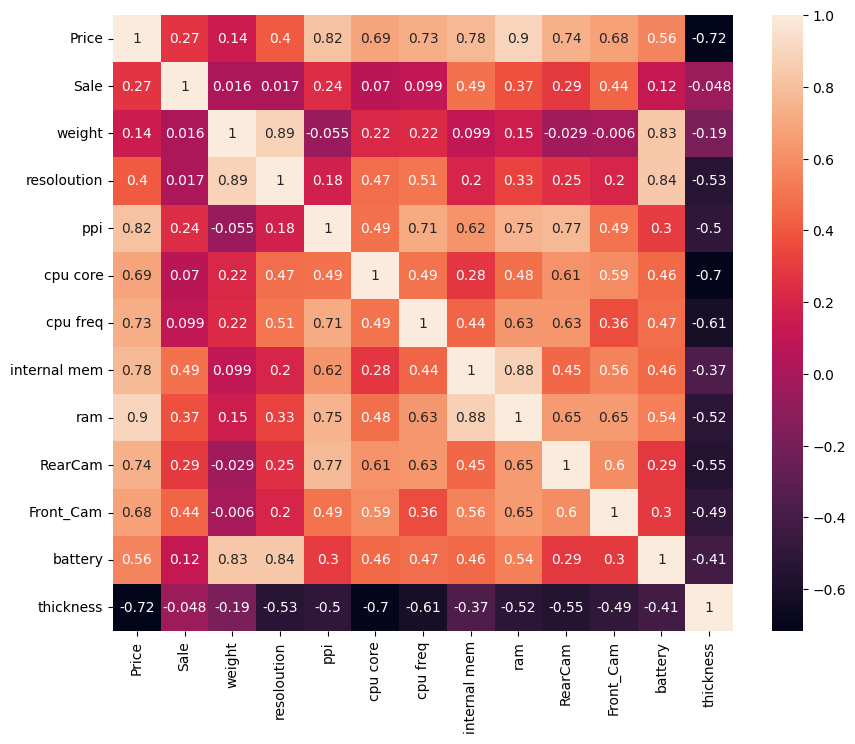

In [ ]:
# Se observa un gráfico de correlación
plt.figure(figsize = (10, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

  Se hace un gráfico de distribuciones de probabilidad,

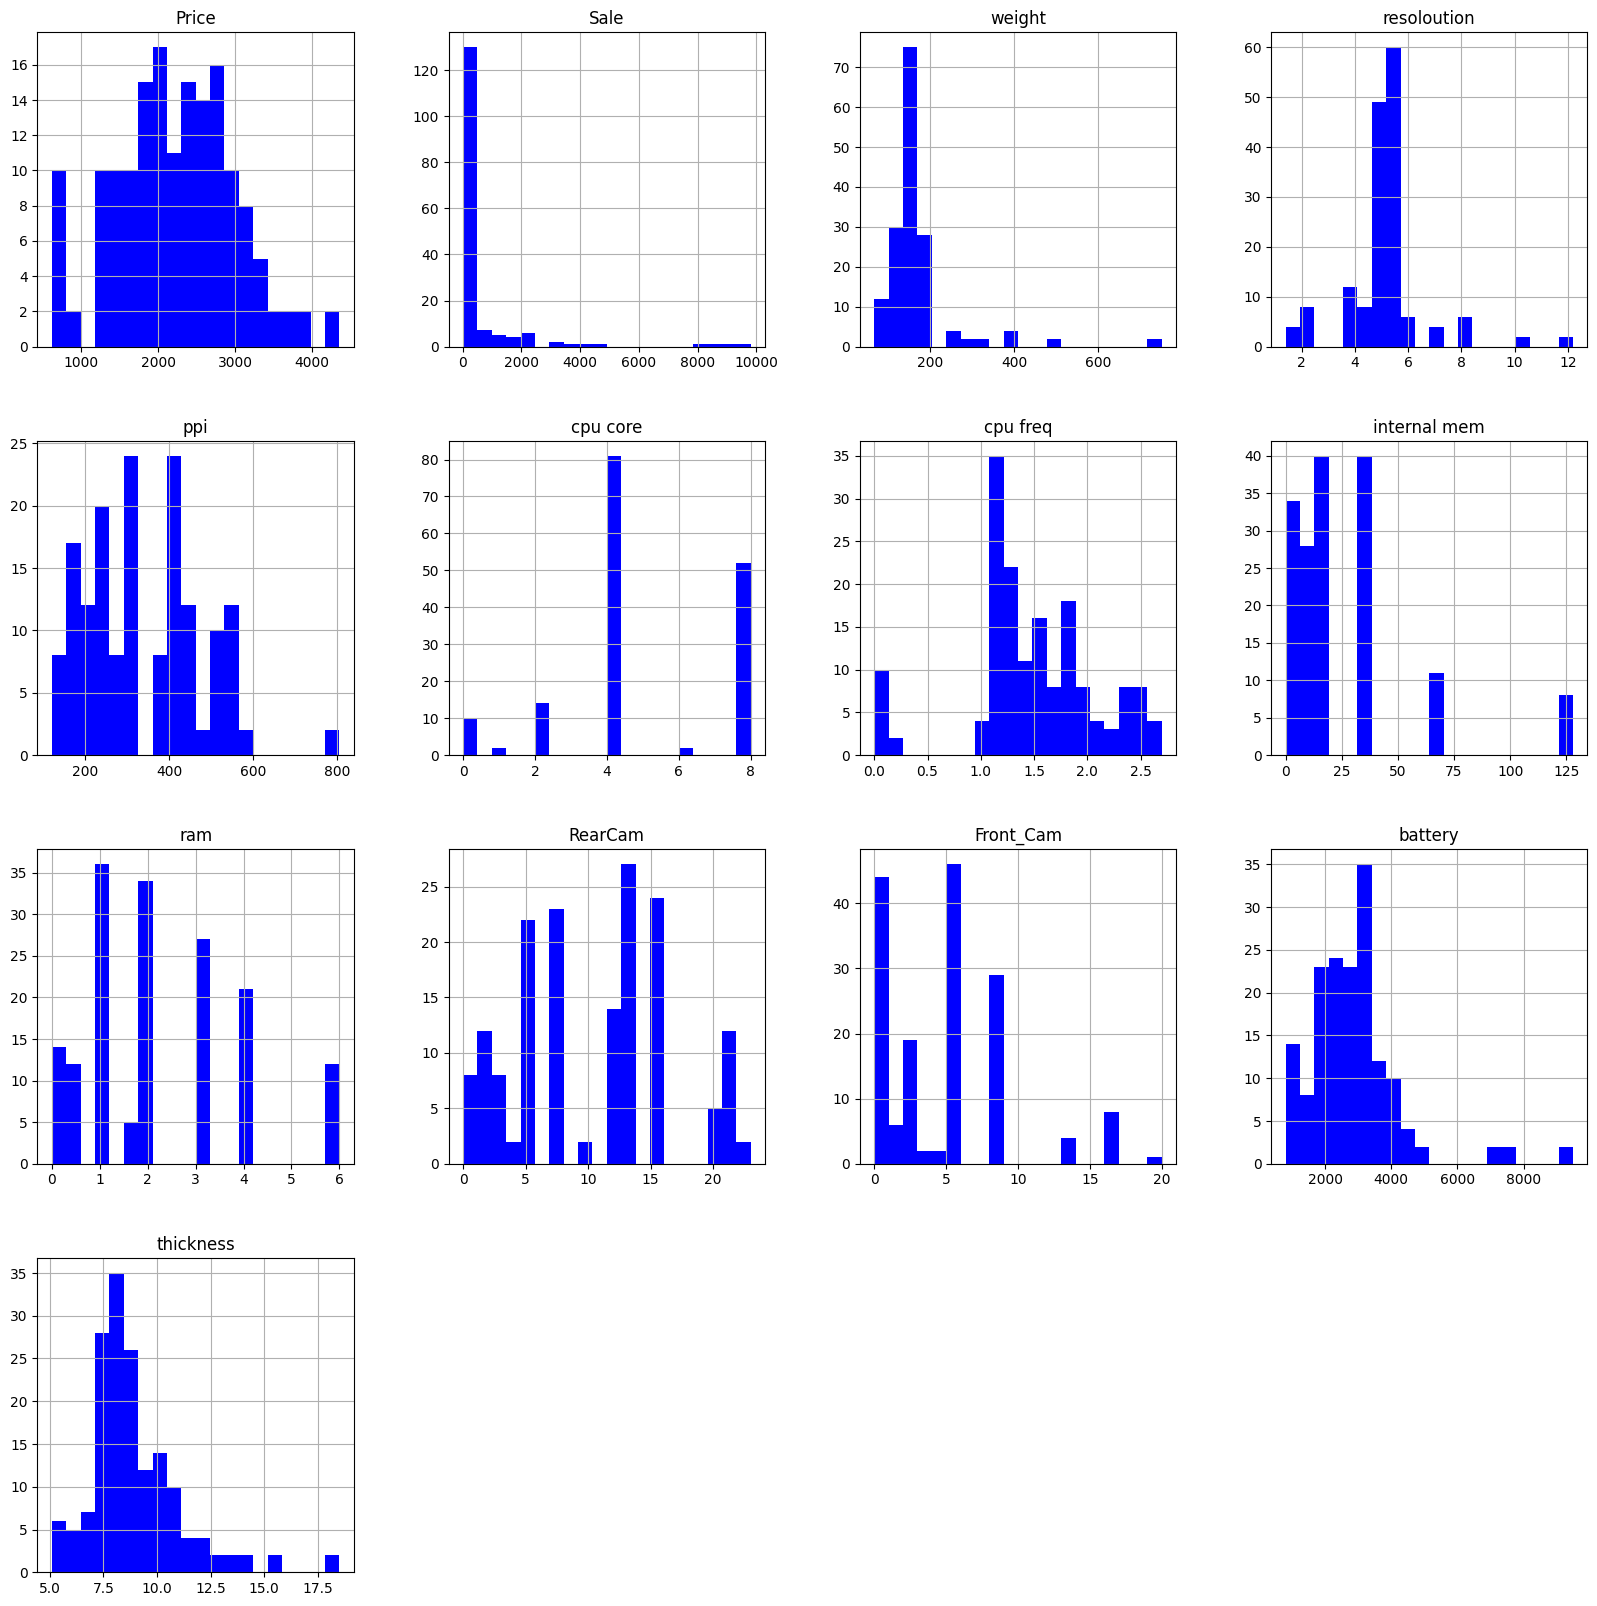

In [ ]:
df.hist(bins = 20, figsize = (20, 20), color = 'b')
plt.show()

## Preprocesamiento de Datos

In [ ]:
# Obtenemos los vectores
X = df.drop('Price', axis=1).values
y = df['Price'].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_indices = [df.columns.get_loc(col) for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1] - 1) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices)],
                    remainder='passthrough')

## Separación en Base de datos de Entrenamiento y Prueba

In [ ]:
# Se divide la base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

## Escalado de Datos

In [ ]:
# Se escalan las variables y se hace one-hot encoder
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
# Se visualiza el array X_train
print(X_train)

[[3.248e+03 2.380e+02 5.700e+00 ... 8.000e+00 7.000e+03 7.400e+00]
 [1.790e+02 1.870e+02 6.000e+00 ... 1.300e+01 2.930e+03 8.200e+00]
 [5.200e+01 1.680e+02 5.150e+00 ... 8.000e+00 3.350e+03 7.500e+00]
 ...
 [1.600e+01 1.450e+02 5.100e+00 ... 2.000e+00 2.800e+03 8.100e+00]
 [1.560e+02 1.540e+02 5.000e+00 ... 5.000e+00 2.100e+03 8.400e+00]
 [2.040e+02 1.600e+02 5.000e+00 ... 0.000e+00 2.500e+03 1.080e+01]]


## Entrenamiento del Modelo

Ahora vamos con el modelo AdaBoost para regresión,

In [ ]:
AdaBoost_model = AdaBoostRegressor(n_estimators = 50, learning_rate = 0.1, random_state = 42)
AdaBoost_model.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.1, random_state=42)

Realizando una predicción,

In [ ]:
# Se debe de hacer en el orden original
print("Predicción:", AdaBoost_model.predict(ct.transform([[10, 135.0, 5.2, 424, 8, 1.30, 4.0, 0.512, 3.15, 0.0, 1400, 11.0]]))[0])

Predicción: 2025.0


In [ ]:
# Obtenemos las predicciones
y_pred = AdaBoost_model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[ 741.83333333]
 [1875.125     ]
 [2645.45945946]
 [1683.06896552]
 [1662.55555556]
 [1800.19047619]
 [ 741.83333333]
 [1518.68421053]
 [2430.75862069]
 [2645.45945946]
 [1392.28571429]
 [1692.19230769]
 [1789.93333333]
 [2949.54054054]
 [2282.68965517]
 [2282.68965517]
 [2388.10344828]
 [3389.15384615]
 [1683.06896552]
 [2282.68965517]
 [2240.85714286]
 [1789.93333333]
 [2050.9047619 ]
 [2483.35      ]
 [2942.36170213]]


## Rendimiento del Modelo

In [ ]:
# KPI's del Modelo
MAE = mean_absolute_error(y_test, y_pred)
print('MAE: {:0.2f}%'.format(MAE / np.mean(y_test) * 100))
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
print('RMSE: {:0.2f}%'.format(RMSE / np.mean(y_test) * 100))
r2 = r2_score(y_test, y_pred)
print('R2: {:0.2f}'.format(r2))

MAE: 6.74%
RMSE: 7.85%
R2: 0.93


## Método del Codo para diferentes Árboles

Se hace un gráfico mirando cómo evoluciona el error a medida que se aumenta el número de árboles a entrenar,

In [ ]:
error_rates = []

for n in range(1, 101):
  model = AdaBoostRegressor(n_estimators = n)
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  err = np.sqrt(mean_squared_error(y_test, preds)) / np.mean(y_test) * 100
  error_rates.append(err)

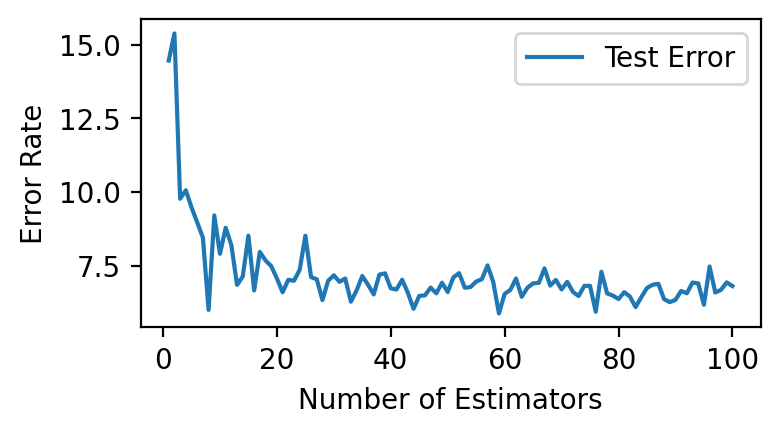

In [ ]:
plt.figure(figsize=(4, 2), dpi=200)
plt.plot(range(1, 101), error_rates, label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("Number of Estimators")
plt.show()

Mirando el gráfico, no se es concluyente en qué cantidad de estimadores se tiene el mejor rendimiento, por lo que se utilizará validación cruzada.

## Validación Cruzada y Grid Search

Se mide el error cuadrático medio para la diferente selección de datos de entrenamiento y prueba,

In [ ]:
# Aplicar K-fold Cross Validation
scores = cross_val_score(estimator = AdaBoost_model, X = X_train, y = y_train, cv = 10, scoring = 'neg_mean_squared_error')
print(np.sqrt(-scores.mean()))

210.55019951499835


Se conocen los parámetros de AdaBoost para evaluar el GridSearch.


In [ ]:
AdaBoost_model = AdaBoostRegressor(estimator = DecisionTreeRegressor(random_state=42), random_state = 42)

In [ ]:
# Parámetros
AdaBoost_model.get_params().keys()

dict_keys(['estimator__ccp_alpha', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__min_impurity_decrease', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__monotonic_cst', 'estimator__random_state', 'estimator__splitter', 'estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [ ]:
# Se establecen los parámetros a probar
parameters = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.5, 1],
    "estimator__max_depth": [1, 2, 3],
    "loss": ["linear", "square", "exponential"]}

In [ ]:
# Se utiliza GridSearchCV
full_cv_classifier = GridSearchCV(estimator = AdaBoost_model,
                                  param_grid = parameters,
                                  cv = 10,
                                  scoring = 'neg_mean_squared_error',
                                  n_jobs = -1,
                                  verbose = 2)

In [ ]:
# Se entrena el CV_Classifier
full_cv_classifier.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10,
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(random_state=42),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [1, 2, 3],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print(full_cv_classifier.best_params_)

{'estimator__max_depth': 3, 'learning_rate': 1, 'loss': 'linear', 'n_estimators': 200}


In [ ]:
# Se obtiene el mejor resultado
print(np.sqrt(-full_cv_classifier.best_score_))

168.7770175687231


Ahora se vuelve a entrenar el modelo, pero con los parámetros óptimos.

In [ ]:
model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3, random_state=42), n_estimators=200,
    learning_rate=1, loss='linear', random_state=42)
model.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
                  learning_rate=1, n_estimators=200, random_state=42)

In [ ]:
# Obtenemos las predicciones
y_pred = model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[ 719.        ]
 [1827.47368421]
 [2525.36363636]
 [1632.66666667]
 [1556.44      ]
 [1932.5       ]
 [ 719.5       ]
 [1534.        ]
 [2375.61111111]
 [2525.36363636]
 [1468.19047619]
 [1650.15789474]
 [1811.29166667]
 [2789.9375    ]
 [2115.2962963 ]
 [2123.16666667]
 [2402.45454545]
 [3276.18181818]
 [1619.33333333]
 [2123.16666667]
 [2319.24      ]
 [1811.29166667]
 [2060.44444444]
 [2463.17647059]
 [2861.5       ]]


In [ ]:
# Obteniendo la precisión del modelo
print('RMSE: {:0.2f}%'.format(np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test) * 100))
print('MAE: {:0.2f}%'.format(mean_absolute_error(y_test, y_pred) / np.mean(y_test) * 100))
print('R2: {:0.2f}%'.format(r2_score(y_test, y_pred) * 100))

RMSE: 6.50%
MAE: 5.55%
R2: 95.29%


## Referencias

*   Hastie, T., Friedman, J., & Tibshirani, R. (2001). The elements of statistical learning. In Springer series in statistics. https://doi.org/10.1007/978-0-387-21606-5
*   Jacinto, V. R. (2024). Machine learning: Fundamentos, algoritmos y aplicaciones para los negocios, industria y finanzas. Ediciones Díaz de Santos.
*   James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R. https://link.springer.com/content/pdf/10.1007/978-1-0716-1418-1.pdf
*   Mobile price prediction. (2022, August 21). Kaggle. https://www.kaggle.com/datasets/mohannapd/mobile-price-prediction
*   Vandeput, N. (2021). Data science for supply chain forecasting. de Gruyter.